In [2]:

import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from io import BytesIO
import sys
import json
import pprint
from mplsoccer import Pitch
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal


matchids = (1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725,
2015213, 2017461)


def data_loader_single_match(match_id: int):
    match = pd.read_csv(f'{match_id}/{match_id}_dynamic_events.csv', low_memory= False)
    match['matchid'] = match['match_id']
    
    #match = match.rename(columns = {'associated_player_possession_event_id': 'assc_evnt_id'})
    
    #match = match.set_index(['matchid', 'event_id', 'assc_evnt_id'])
    
    return match

def data_loader_multi_match(match_ids: tuple[int]):
    all_matches = pd.DataFrame()
    for match_id in match_ids:
        match = pd.read_csv(f'{match_id}/{match_id}_dynamic_events.csv', low_memory = False)
        all_matches= pd.concat([all_matches, match], ignore_index =True)
   
   
    #all_matches = all_matches.rename(columns = {'associated_player_possession_event_id': 'assc_evnt_id'})
    #all_matches = all_matches.set_index(['match_id', 'event_id', 'assc_evnt_id'])
   
    return all_matches

def data_loader_single_json(match_id: int):
    with open(f'{match_id}/{match_id}_match.json') as f:
            match_dict =json.load(f)
    return match_dict

def data_loader_multi_json(match_ids: tuple[int]):
    list = []
    for match_id in match_ids:
        dict = data_loader_single_match(match_id)
        list.append(dict)
    return list
          
 



In [3]:

def get_zone_defined_possessions(data: pd.DataFrame, zone: int) -> pd.DataFrame:
    """
    Input a dataframe of dynamic events data and in integer between 1 and 20. Returns all possessions in static possession that begin in that zone.
    Zones defined as such: https://learning.coachesvoice.com/wp-content/webpc-passthru.php?src=https://learning.coachesvoice.com/wp-content/uploads/2022/05/Tactics1.png&nocache=1
    Input 19 for the left attacking half space, and 20 for the right attacking half space

    Composite key for each record: 'match_id' and 'event_id'
    """

    #Keep only player possessions
    is_possession: pd.Series[bool] = data['event_type'] == 'player_possession'
    #Keep only possessions vs blocks
    is_vs_block: pd.Series[bool] = data['team_out_of_possession_phase_type'].isin(['high_block', 'medium_block','low_block'])


    depths: dict[str, pd.Series[bool]] = {
        'depth_1': data['x_start'] <= -35.34,
        'depth_2' : data['x_start'].between(-35.34, -17.66, inclusive= 'right'),
        'depth_3' : data['x_start'].between(-17.66, 0, inclusive = 'right'),
        'depth_4' : data['x_start'].between(0, 17.66, inclusive = 'right'),
        "depth_5" : data['x_start'].between(17.66, 35.34, inclusive = 'right'),
        "depth_6" : data['x_start'] >= 35.34
    }
    widths: dict[str, pd.Series[bool]] = {
        'width_left' : data['channel_id_start'].isin([1,2]),
        "width_center" : data['channel_id_start']== 3,
        "width_right" :data['channel_id_start'].isin([4,5]),
        "half_space_left" : data['channel_id_start'] == 2,
        "half_space_right" : data['channel_id_start'] == 4
    }
    

    zone_values = {
        1: ("depth_1", "width_left"),
        2: ("depth_1", "width_center"),
        3: ("depth_1", "width_right"),
        4: ("depth_2", "width_left"),
        5: ("depth_2", "width_center"),
        6: ("depth_2", "width_right"),
        7: ("depth_3", "width_left"),
        8: ("depth_3", "width_center"),
        9: ("depth_3", "width_right"),
        10: ("depth_4", "width_left"),
        11: ("depth_4", "width_center"),
        12: ("depth_4", "width_right"),
        13: ("depth_5", "width_left"),
        14: ("depth_5", "width_center"),
        15: ("depth_5", "width_right"),
        16: ("depth_6", "width_left"),
        17: ("depth_6", "width_center"),
        18: ("depth_6", "width_right"),
        19: ("depth_5", "half_space_left"),
        20: ("depth_5", "half_space_right"),
    }

    zone_value: tuple[str, str] = zone_values[zone]
    depth = depths[zone_value[0]]
    width = widths[zone_value[1]]

    mask = is_possession & is_vs_block & depth & width
    

    filtered_df = data.loc[mask].copy()

    return filtered_df




Example of a zone defined possession dataframe

In [ ]:
df = data_loader_single_match(1886347)
get_zone_defined_possessions(df, 14)



,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xloss_player_possession_max,xshot_player_possession_start,xshot_player_possession_end,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,matchid
166,8_32,166,1886347,1433,1444,NaN,02:22.3,02:23.4,2,22,...,NaN,NaN,NaN,NaN,True,True,True,NaN,False,1886347
515,8_103,515,1886347,4236,4236,NaN,07:02.6,07:02.6,7,2,...,NaN,NaN,NaN,NaN,True,True,True,NaN,False,1886347
1648,8_324,1648,1886347,16216,16216,NaN,27:00.6,27:00.6,27,0,...,NaN,NaN,NaN,NaN,True,True,NaN,True,False,1886347
1653,8_325,1653,1886347,16224,16234,NaN,27:01.4,27:02.4,27,1,...,NaN,NaN,NaN,NaN,True,True,True,True,False,1886347
2089,8_413,2089,1886347,20367,20386,NaN,33:55.7,33:57.6,33,55,...,NaN,NaN,NaN,NaN,True,True,NaN,True,False,1886347
2119,8_418,2119,1886347,20513,20529,NaN,34:10.3,34:11.9,34,10,...,NaN,NaN,NaN,NaN,True,True,True,True,False,1886347
2124,8_419,2124,1886347,20537,20537,NaN,34:12.7,34:12.7,34,12,...,NaN,NaN,NaN,NaN,True,True,True,True,False,1886347
2814,8_559,2814,1886347,28619,28647,NaN,46:21.9,46:24.7,46,21,...,NaN,NaN,NaN,NaN,False,False,NaN,True,False,1886347
2890,8_573,2890,1886347,29175,29185,NaN,47:17.5,47:18.5,47,17,...,NaN,NaN,NaN,NaN,True,True,True,True,False,1886347
3110,8_620,3110,1886347,30915,30929,NaN,50:11.5,50:12.9,50,11,...,NaN,NaN,NaN,NaN,True,True,True,True,False,1886347


In [ ]:
### Not currently used for anything
def get_match_counts_multi_match(data: pd.DataFrame):
    match_counts = (
        data[['player_id', 'match_id']]
        .drop_duplicates()                  
        .groupby('player_id')
        .agg(matches_played=('match_id', 'count'))
        .reset_index()
    )
    return match_counts

In [ ]:
### this can be way more efficient
def get_minute_counts(data:dict):
    """
    Input a skillcorner match information dict, output player minutes and other relevant information as a dataframe

    """
    columns = ['player_name','player_id', 'match_id','minutes','position']
    minutesinfo = pd.DataFrame(columns= columns)

    for player in data['players']:
        match_id = data['id']
        player_id = player['id']
        player_name = player['short_name']
        playing_time = float(player['playing_time']['total']['minutes_played'] if player['playing_time'] and player['playing_time']['total'] else '0')
        position = player['player_role']['acronym']
        minutesinfo.loc[len(minutesinfo)] = [player_name, player_id, match_id, playing_time, position]

    return minutesinfo


In [7]:
def get_df_minutes(data: pd.DataFrame) -> pd.DataFrame:

    dfs = []   

    for match_id in data['match_id'].unique():
        dict = data_loader_single_json(match_id)
        df = get_minute_counts(dict)
        dfs.append(df)


    all_minutes = pd.concat(dfs, ignore_index=True)
    
    out = (
        all_minutes.groupby(['player_id', 'player_name'])
            .agg(
                total_minutes=('minutes', 'sum'),
                match_ids     = ('match_id', list),
                positions=('position', lambda x: sorted(set(x)))
            )
            .reset_index()
    )

    out = out.sort_values('total_minutes', ascending= False)

    return out

In [ ]:
def get_zone_summary(data: pd.DataFrame, zone: int):
    ### aggregator
    summary = (
        get_zone_defined_possessions(data, zone)
        .groupby(['player_id', 'player_name'])
        .agg(total_actions= ('index', 'count'))
        .reset_index()
    )
    minutes_counts = get_df_minutes(data)
    summary = summary.merge(minutes_counts, on = ['player_id', 'player_name'], how = 'left')
    summary['ta/90'] = summary['total_actions']/(summary['total_minutes']/90)
    summary = summary.sort_values('ta/90', ascending = False)
    return summary

In [ ]:



def get_zone_movers_carries(data: pd.DataFrame, filter:bool = False):
    """
    input a dynamic events df, output a df with a zones_moved_forward field. Only considers zone moving carries Zones moved forwards are positive, zones moved backwards are negative

    if filter = True, returns a df of only zone moving carries. If false, returns a df of all player possessions with added zone mover columns
    """
    # x_start_bucket = ...
    # return get_zone_movers(data=data, mover_type='carries', filter = filter)

    moving = data.loc[data['event_type'] == 'player_possession'].copy()

    bins = [-1000, -35.34, -17.66, 0, 17.66, 35.34, 1000]
    labels = [1, 2, 3, 4, 5, 6]


    x_start_bucket = pd.cut(moving['x_start'], bins=bins, labels=labels)
    x_end_bucket   = pd.cut(moving['x_end'], bins=bins, labels=labels)


    moving['x_start_bucket'] = x_start_bucket.astype('int64')
    moving['x_end_bucket']   = x_end_bucket.astype('int64')

    moving['zones_moved_forward'] = x_end_bucket.astype('int64') - x_start_bucket.astype('int64')

    if filter is True:
        moving = moving.loc[moving['zones_moved_forward'] != 0]

    return moving




In [ ]:

def get_zone_movers_passes(data: pd.DataFrame, filter: bool = False):
    """
    Input a dynamic events df, output a df with a zones_moved_forward field. Only considers passing zone movements. Zones moved forwards are positive, zones moved backwards are negative

    if filter = True, returns a df of only zone moving carries. If false, returns a df of all player possessions with added zone mover columns
    """
    moving = data.loc[data['event_type'] == 'player_possession'].copy()
    moving = moving.loc[moving['player_targeted_x_reception'].isna() == False].copy()
    
    bins = [-1000, -35.34, -17.66, 0, 17.66, 35.34, 1000]
    labels = [1, 2, 3, 4, 5, 6]

    x_start_bucket = pd.cut(moving['x_end'], bins=bins, labels=labels)
    x_end_bucket   = pd.cut(moving['player_targeted_x_reception'], bins=bins, labels=labels)

   
    moving['pass_zone'] = x_start_bucket.astype(int)
    moving['reception_zone'] = x_end_bucket.astype(int)

    
  
     
    #only consider player possessions ending in successful passes

    #this should be toggleable at some point
    
    zones_moved_forward = moving['reception_zone'] - moving['pass_zone']
    zones_moved_forward = zones_moved_forward.fillna(0)
    moving['zones_moved_forward'] = zones_moved_forward.astype(int)
    if filter == True:
        moving = moving.loc[moving['zones_moved_forward'] != 0]


    return moving


   







In [20]:
def get_zone_movers_summary_helper(data: pd.DataFrame, type: str = 'pass'):
    
    if type == 'pass':
            df = get_zone_movers_carries(data)
    elif type == 'carry':
            df = get_zone_movers_passes(data)
    else:
        raise ValueError('type must be pass, carry, or both')
    summary = (
        df
        .groupby(['player_id', 'player_name'])
        .agg(zones_moved = ('zones_moved_forward', 'sum'))
    )
    minutes_counts = get_df_minutes(data)
    summary = summary.merge(minutes_counts, on = ['player_id', 'player_name'], how = 'left')
    summary['zm/90'] = summary['zones_moved']/(summary['total_minutes']/90)
    summary = summary.sort_values('zm/90', ascending = False)
    
    return summary

    


In [ ]:
def get_zone_movers_summary(df, type_: str = 'pass'):

    """
    Generates zone mover summary from Dynamic Events dataframe. 

    Accepts a dataframe of dynamic events and a string reading "pass", "carry", or "both" to determine type
    """

    if type_ == 'pass':
        summary = get_zone_movers_summary_helper(df, 'pass')
    elif type_ == 'carry':
        summary = get_zone_movers_summary_helper(df, 'carry')
    elif type_ == 'both':
        df1 = get_zone_movers_summary_helper(df, 'pass')
        df2 = get_zone_movers_summary_helper(df, 'carry')
        summary = df1.merge(df2, on = ['player_id', 'player_name', 'total_minutes'], how = 'left')
        columns_drop = (['match_ids_y', 'positions_y'])
        summary = summary.drop(columns_drop, axis = 1)
        new_order = ['player_id',	'player_name',	'total_minutes', 'positions_x' ,	'zones_moved_x', 	'zm/90_x',	'zones_moved_y',	'zm/90_y', 'match_ids_x']
        summary = summary.reindex(columns=new_order)
        summary.rename(columns={'positions_x': 'positions', 'zones_moved_x' : 'zones_moved_carrying', 'zones_moved_y' : 'zones_moved_passing',
                                'zm/90_x' : 'zmc/90', 'zm/90_y' : 'zmp/90', 'match_ids_x': 'matchids'}, inplace=True)
        summary['zones_moved'] = summary['zones_moved_passing'] + summary['zones_moved_carrying']
        summary['zm/90'] = summary['zmp/90'] + summary['zmc/90']
        summary = summary.sort_values('zm/90', ascending = False)
    else: 
        raise ValueError('type_ must be pass, carry, or both')
        

    return summary




In [44]:

def get_zone_movers_viz(data: pd.DataFrame, player_id: int):
    """
    takes a SkillCorner dynamic events df and a playerid
    generates a pitch visualization of a player's (successful) zone movers in a given df
    green dashed lines are passes, red solid lines are runs with the ball

    needs matplotlib pyplot, seaborn, mplsoccer
    """
    passes  = get_zone_movers_passes(data, True)

    carries = get_zone_movers_carries(data, True)

    
    pp = passes.loc[passes['player_id'] == player_id]
    pc = carries.loc[carries['player_id'] == player_id]

    #print("passing " + str(pp['zones_moved_forward'].sum()))
    #print("carrying " + str(pc['zones_moved_forward'].sum()))
  
    pitch = Pitch(pitch_type='skillcorner', pitch_length=106, pitch_width=68,
              axis=True, label=True, positional=True, shade_middle=True)
    fig, ax = pitch.draw()

    for event in range(len(pp)):
        row = pp.iloc[event]
        ax.plot(
        (row['x_end'], row['player_targeted_x_reception']),
        (row['y_end'], row['player_targeted_y_reception']),
        color='green', ls='dashed'
        )

        ax.scatter(row['x_end'], row['y_end'], color='green', s=40, zorder=5)

    for event in range(len(pc)):
        row = pc.iloc[event]
        ax.plot(
        (row['x_start'], row['x_end']),
        (row['y_start'], row['y_end']),
        color='red'
        )

        ax.scatter(row['x_start'], row['y_start'], color='red', s=40, zorder=5)
    
    name: str = pp['player_name'].unique()[0]
    plt.title('Zone mover map for ' + name)

    
    return pitch
    
    







    







In [46]:
df = data_loader_multi_match(matchids)

summary = get_zone_movers_summary(df, 'both')
summary[summary['total_minutes'] > 45]

,player_id,player_name,total_minutes,positions,zones_moved_carrying,zmc/90,zones_moved_passing,zmp/90,matchids,zones_moved,zm/90
2,28293,Léo Sena,96.00,[LDM],16,15.000000,28.0,26.250000,[1996435],44.0,41.250000
4,965697,L. Herrington,102.13,[RCB],16,14.099677,14.0,12.337217,[1925299],30.0,26.436894
18,809759,P. Kikianis,96.00,[LCB],9,8.437500,18.0,16.875000,[1996435],27.0,25.312500
162,50999,M. Freke,102.13,[GK],0,0.000000,27.0,23.793205,[1925299],27.0,23.793205
183,560985,C. Cook,102.13,[GK],0,0.000000,25.0,22.030745,[1925299],25.0,22.030745
...,...,...,...,...,...,...,...,...,...,...,...
203,771856,B. Mazzeo,59.06,[RF],-3,-4.571622,-4.0,-6.095496,[1953632],-7.0,-10.667118
86,51051,C. Talbot,98.72,"[RB, SUB]",3,2.735008,-15.0,-13.675041,"[1953632, 2006229]",-12.0,-10.940032
205,51039,N. Smith,57.11,[LWB],-4,-6.303625,-3.0,-4.727718,[1953632],-7.0,-11.031343
156,808609,B. Brandtman,48.26,[RW],0,0.000000,-6.0,-11.189391,[1953632],-6.0,-11.189391


Zone mover map for Léo Sena, the clear zone moving champion. He was a Serie A level player a few years ago but keeps dropping down the leagues and is now a free agent (I think because he's a total dick)

Pitch(pitch_type='skillcorner', half=False, pitch_color='white', line_color='#b0b0b0', linewidth=2, line_zorder=0.9, linestyle=None, stripe=False, stripe_color='#c2d59d', stripe_zorder=0.6, pad_left=4, pad_right=4, pad_bottom=4, pad_top=4, positional=True, positional_zorder=0.8, positional_linewidth=2, positional_linestyle=None, positional_color='#eadddd', positional_alpha=1, shade_middle=True, shade_color='#f2f2f2', shade_alpha=1, shade_zorder=0.7, pitch_length=106, pitch_width=68, goal_type='line', goal_alpha=1, line_alpha=1, label=True, tick=False, axis=True, spot_scale=0.024, spot_type='circle'), corner_arcs=False)

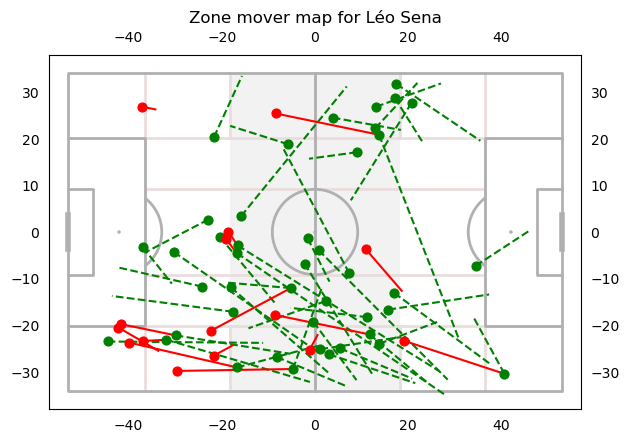

In [43]:
get_zone_movers_viz(df, 28293)

Zone mover map for Callum Talbot. How is it possible to have that many backwards passes.

Pitch(pitch_type='skillcorner', half=False, pitch_color='white', line_color='#b0b0b0', linewidth=2, line_zorder=0.9, linestyle=None, stripe=False, stripe_color='#c2d59d', stripe_zorder=0.6, pad_left=4, pad_right=4, pad_bottom=4, pad_top=4, positional=True, positional_zorder=0.8, positional_linewidth=2, positional_linestyle=None, positional_color='#eadddd', positional_alpha=1, shade_middle=True, shade_color='#f2f2f2', shade_alpha=1, shade_zorder=0.7, pitch_length=106, pitch_width=68, goal_type='line', goal_alpha=1, line_alpha=1, label=True, tick=False, axis=True, spot_scale=0.024, spot_type='circle'), corner_arcs=False)

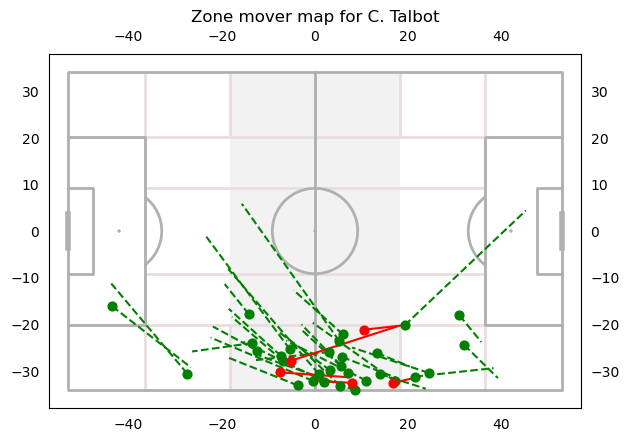

In [47]:
get_zone_movers_viz(df, 51051)

Experimental section starts here. Trying to organize my zone receptions code into classes

In [ ]:
class Validators:

    @staticmethod
    def ensure_tuple_of_ints(input_val: int | tuple[int]) -> tuple[int]:
        if isinstance(input_val, int):
            return (input_val)
        if isinstance(input_val, list):
            if all([isinstance(x, tuple) for x in input_val]):
                return input_val
            else:
                raise TypeError('You passed a list (good!), but not all values were integers')
        raise TypeError(f'You must pass a list or int. You passed {type(input_val)}')

class DataLoaderSingleMatch:
    def __init__(self, match_id: int):
        self.match_id: int = match_id
    
    def dynamic_events_path(self) -> str:
        return f'{self.match_id}/{self.match_id}_dynamic_events.csv'
    @property
    def match_info_file_name(self) -> str:
        return f'{self.match_id}/{self.match_id}_match.json'
    
    def load_match_info(self) -> dict:
        with open(self.match_info_file_name) as f:
            match_dict = json.load(f)
        return match_dict    
    
class DataLoader:
    def __init__(self, match_ids: int | list[int]) -> None:
        self.match_ids: list[int] = Validators.ensure_tuple_of_ints(match_ids)

    xx_test_matchids = (1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461)

    @classmethod
    def data_loader_single_match(cls, match_id: int):
        file_name= DataLoaderSingleMatch(match_id).dynamic_events_path()
        match: pd.DataFrame = pd.read_csv(file_name, low_memory= False)
        return match

    def data_loader_multi_match(self) -> pd.DataFrame:
        all_match_dfs: list[pd.DataFrame] = []
        for match_id in self.match_ids:
            match: pd.DataFrame = self.data_loader_single_match(match_id = match_id)
            all_match_dfs.append(match)
        all_matches= pd.concat(all_match_dfs, ignore_index =True)
        return all_matches

    def data_loader_single_json(self, match_id: int) -> dict:
        obj = DataLoaderSingleMatch(match_id=match_id)
        return obj.load_match_info()

    def data_loader_multi_json(self, match_ids: tuple[int]):
        objs: list[DataLoaderSingleMatch] = []
        for match_id in match_ids:
            objs.append(DataLoaderSingleMatch(match_id))
        match_infos = []
        for obj in objs:
            match_infos.append(obj.load_match_info())
        return match_infos

class FieldZone:

    zone_values: dict[int, tuple[str, str]] = {
            1: ("depth_1", "width_left"),
            2: ("depth_1", "width_center"),
            3: ("depth_1", "width_right"),
            4: ("depth_2", "width_left"),
            5: ("depth_2", "width_center"),
            6: ("depth_2", "width_right"),
            7: ("depth_3", "width_left"),
            8: ("depth_3", "width_center"),
            9: ("depth_3", "width_right"),
            10: ("depth_4", "width_left"),
            11: ("depth_4", "width_center"),
            12: ("depth_4", "width_right"),
            13: ("depth_5", "width_left"),
            14: ("depth_5", "width_center"),
            15: ("depth_5", "width_right"),
            16: ("depth_6", "width_left"),
            17: ("depth_6", "width_center"),
            18: ("depth_6", "width_right"),
            19: ("depth_5", "half_space_left"),
            20: ("depth_5", "half_space_right"),
        }

    def __init__(self, df_data: pd.DataFrame) -> None:
        self.df_data: pd.DataFrame = df_data

    def get_depth_mask(self, depth_term: str) -> pd.Series:
        x_starts: pd.Series[float] = self.df_data['x_start']
        match depth_term:
            case 'depth_1':
                return x_starts <= -35.34
            case 'depth_2':
                return x_starts.between(-35.34, -17.66, inclusive= 'right')
            case 'depth_3':
                return x_starts.between(-17.66, 0, inclusive = 'right')
            case 'depth_4':
                return x_starts.between(0, 17.66, inclusive = 'right')
            case 'depth_5':
                return x_starts.between(17.66, 35.34, inclusive = 'right')
            case 'depth_6':
                return x_starts >= 35.34
            case _:
                raise ValueError('You did not pass a valid depth term')
            

    def get_width_mask(self, width_term: str) -> pd.Series:
        y_starts: pd.Series[float] = self.df_data['channel_id_start']
        match width_term:
            case 'width_left':
                return y_starts.isin([1,2])
            case 'width_center':
                return y_starts == 3
            case 'width_right':
                return y_starts.isin([4,5])
            case 'half_space_left':
                return y_starts == 2
            case 'half_space_right':
                return y_starts == 4
            case _:
                raise ValueError('You did not pass a valid width term')
    



    def get_zone_defined_possessions(self, data: pd.DataFrame, zone: int) -> pd.DataFrame:
        """
        Input a dataframe of dynamic events data and in integer between 1 and 20. Returns all possessions in static possession that begin in that zone.
        Zones defined as such: https://learning.coachesvoice.com/wp-content/webpc-passthru.php?src=https://learning.coachesvoice.com/wp-content/uploads/2022/05/Tactics1.png&nocache=1
        Input 19 for the left attacking half space, and 20 for the right attacking half space

        Composite key for each record: 'match_id' and 'event_id'
        """
        #Keep only player possessions
        is_possession: pd.Series[bool] = data['event_type'] == 'player_possession'
        #Keep only possessions vs blocks
        is_vs_block: pd.Series[bool] = data['team_out_of_possession_phase_type'].isin(['high_block', 'medium_block','low_block'])
  
        depth = self.get_depth_mask(self.zone_values[zone][0])

        width = self.get_width_mask(self.zone_values[zone][1])

        mask = is_possession & is_vs_block & depth & width
        
        filtered_df = data.loc[mask].copy()

        return filtered_df


Better way to read the JSONs

In [ ]:
d = data_loader_single_json(1886347)
df = pd.json_normalize(d)
df_players = pd.json_normalize(df.iloc[0]['players'], sep='>')

df_players.head()